In [1]:
11

11

## packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

In [3]:
from google.colab import drive
drive.mount('/content/mydrive/')

Drive already mounted at /content/mydrive/; to attempt to forcibly remount, call drive.mount("/content/mydrive/", force_remount=True).


## csvs

In [4]:
train = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/train.csv')
train.head(1)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950


In [5]:
test = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/test.csv')
test.head(1)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max
0,2021-01-01,NaN,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1


In [6]:
# 프로젝트의 목표 : 따릉이 대여량 예측
submission = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/sample_submission.csv')
submission.head(1)

,date,rental
0,2021-01-01,0


## preprocessing


### train set

In [7]:
# add columns year, month, day, and day_of_week
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
train['year'] = train['date'].dt.year 
train['month'] = train['date'].dt.month 
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek

# remove entire sample with PM10 and PM2.5 missing values
train.dropna(axis=0, subset=['PM10', 'PM2.5'], inplace=True)

# replace sunshine_sum and precipitaion missing values with 0 and also drop out column date
imp_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
imputed_train = pd.DataFrame(imp_zero.fit_transform(train.select_dtypes(exclude=['datetime64[ns]'])))
imputed_train.columns = ['precipitation',
                         'temp_mean',
                         'temp_highest',
                         'temp_lowest',
                         'PM10',
                         'PM2.5',
                         'humidity',
                         'sunshine_sum',
                         'sunshine_rate',
                         'wind_mean',
                         'wind_max',
                         'rental',
                         'year',
                         'month', 
                         'day',
                         'day_of_week']

# from float64 to int64
imputed_train['year'] = imputed_train['year'].astype(int)
imputed_train['month'] = imputed_train['month'].astype(int)
imputed_train['day'] = imputed_train['day'].astype(int)
imputed_train['day_of_week'] = imputed_train['day_of_week'].astype(int)

# rename imputed_train as train for convenience
train = imputed_train

### test set

In [8]:
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.dayofweek


imputed_test = pd.DataFrame(imp_zero.fit_transform(test.select_dtypes(exclude=['datetime64[ns]'])))
imputed_test.columns = ['precipitation',
                         'temp_mean',
                         'temp_highest',
                         'temp_lowest',
                         'PM10',
                         'PM2.5',
                         'humidity',
                         'sunshine_sum',
                         'sunshine_rate',
                         'wind_mean',
                         'wind_max',
                         'year',
                         'month', 
                         'day',
                         'day_of_week']

imputed_test['year'] = imputed_test['year'].astype(int)
imputed_test['month'] = imputed_test['month'].astype(int)
imputed_test['day'] = imputed_test['day'].astype(int)
imputed_test['day_of_week'] = imputed_test['day_of_week'].astype(int)

test = imputed_test

### result

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  1026 non-null   float64
 1   temp_mean      1026 non-null   float64
 2   temp_highest   1026 non-null   float64
 3   temp_lowest    1026 non-null   float64
 4   PM10           1026 non-null   float64
 5   PM2.5          1026 non-null   float64
 6   humidity       1026 non-null   float64
 7   sunshine_sum   1026 non-null   float64
 8   sunshine_rate  1026 non-null   float64
 9   wind_mean      1026 non-null   float64
 10  wind_max       1026 non-null   float64
 11  rental         1026 non-null   float64
 12  year           1026 non-null   int64  
 13  month          1026 non-null   int64  
 14  day            1026 non-null   int64  
 15  day_of_week    1026 non-null   int64  
dtypes: float64(12), int64(4)
memory usage: 128.4 KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  365 non-null    float64
 1   temp_mean      365 non-null    float64
 2   temp_highest   365 non-null    float64
 3   temp_lowest    365 non-null    float64
 4   PM10           365 non-null    float64
 5   PM2.5          365 non-null    float64
 6   humidity       365 non-null    float64
 7   sunshine_sum   365 non-null    float64
 8   sunshine_rate  365 non-null    float64
 9   wind_mean      365 non-null    float64
 10  wind_max       365 non-null    float64
 11  year           365 non-null    int64  
 12  month          365 non-null    int64  
 13  day            365 non-null    int64  
 14  day_of_week    365 non-null    int64  
dtypes: float64(11), int64(4)
memory usage: 42.9 KB


## validation models

In [11]:
y = train.rental
X = train.drop('rental', axis=1)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y,
                                                      train_size=0.8,
                                                      test_size=0.2,
                                                      random_state=0,
                                                      shuffle=True)

In [13]:
rfr = RandomForestRegressor(n_estimators=100, random_state=0)
rfr.fit(X_train, y_train)
preds = rfr.predict(X_valid)
mae = mean_absolute_error(y_valid, preds)
print('MAE : ', mae)

MAE :  5319.827184466019


In [14]:
xgb = XGBRegressor(colsample_bytree=0.7,
                       learning_rate=0.03,
                       max_depth=5,
                       min_child_weight=4,
                       n_estimators=500,
                       nthread=4,
                       objective='reg:squarederror',
                       silent=1,
                       subsample=0.7)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_valid)
mae = mean_absolute_error(y_valid, preds)
print('MAE : ', mae)

MAE :  4441.280934750455


## test model

In [15]:
train = shuffle(train)
train.head(3)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day,day_of_week
464,0.0,23.0,28.8,16.6,24.0,15.0,51.9,12.3,83.7,1.7,4.0,81540.0,2019,6,13,3
703,0.0,6.8,14.6,-0.5,55.0,36.0,37.0,7.6,71.0,1.6,3.6,40563.0,2020,2,11,1
896,0.0,27.8,32.0,23.7,25.0,17.0,71.6,8.8,66.2,2.2,4.9,90297.0,2020,8,24,0


In [16]:
y = train.rental
X = train.drop('rental', axis=1)

In [17]:
test_model = XGBRegressor(colsample_bytree=0.7,
                       learning_rate=0.03,
                       max_depth=5,
                       min_child_weight=4,
                       n_estimators=500,
                       nthread=4,
                       objective='reg:squarederror',
                       silent=1,
                       subsample=0.7)
test_model.fit(X, y)
submission['rental'] = test_model.predict(test)

In [18]:
submission.to_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/submissions/submission-2022-06-16-ik.csv', index=False)

## submission result
- rfr보다 xgbboost의 성능이 더 좋다.


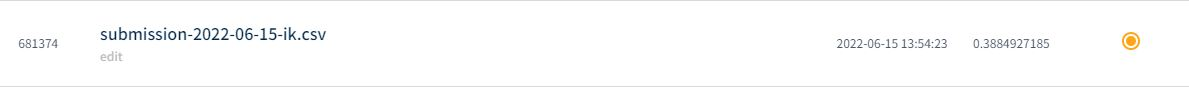

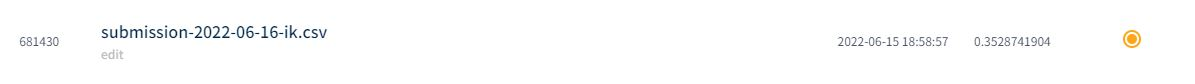